# Create multi-label chips for multi-output regression sampled from the whole GB

Create chips and store proportions of signature types within as an input of multi-output regression problem

In [34]:
import geopandas
import tobler
import pyogrio
import pygeos
import numpy
import pandas
import dask_geopandas
import rasterio
from scipy.sparse import coo_matrix

import dask
import dask.bag
from dask.distributed import Client, LocalCluster

In [2]:
%%time
df = geopandas.read_parquet("/home/jovyan/work/chips_gb/chip_bounds_16/").reset_index(drop=True)

CPU times: user 6.82 s, sys: 1.87 s, total: 8.69 s
Wall time: 7.22 s


In [3]:
df

,geometry
0,"POLYGON ((82861.267 6990.753, 82861.267 6830.7..."
1,"POLYGON ((83181.267 6990.753, 83181.267 6830.7..."
2,"POLYGON ((83981.267 6030.753, 83981.267 5870.7..."
3,"POLYGON ((84941.267 5550.753, 84941.267 5390.7..."
4,"POLYGON ((85421.267 12910.753, 85421.267 12750..."
...,...
6857841,"POLYGON ((555181.267 101870.753, 555181.267 10..."
6857842,"POLYGON ((555181.267 102030.753, 555181.267 10..."
6857843,"POLYGON ((555341.267 101710.753, 555341.267 10..."
6857844,"POLYGON ((555341.267 101870.753, 555341.267 10..."


In [4]:
signatures = pyogrio.read_dataframe(        
        '/home/jovyan/work/urbangrammar_samba/spatial_signatures/'
        'signatures/'
        'signatures_combined_levels_simplified.gpkg'
)

In [5]:
bds = df.total_bounds
signatures = signatures.cx[bds[0]:bds[2], bds[1]:bds[3]]

In [6]:
%%time

ids_src, ids_tgt = df.sindex.query_bulk(signatures.geometry, predicate="intersects")

CPU times: user 2min 50s, sys: 455 ms, total: 2min 51s
Wall time: 2min 51s


In [7]:
od_matrix = pandas.DataFrame(dict(ids_src=ids_src, ids_tgt=ids_tgt))

In [8]:
%%time 
sjoined = df.set_geometry(df.centroid).sjoin(signatures[["signature_type", "geometry"]], how="left", predicate="within")

/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1938: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:27700

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


CPU times: user 26.3 s, sys: 2.03 s, total: 28.3 s
Wall time: 28.3 s


In [9]:
od_matrix["signature_type"] = sjoined.signature_type.iloc[ids_tgt].values

<AxesSubplot:>

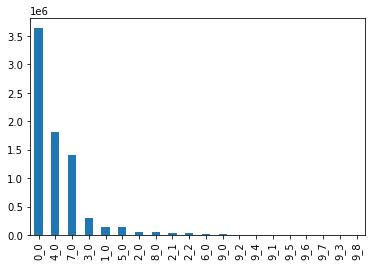

In [10]:
od_matrix.signature_type.value_counts().plot.bar()

In [11]:
od_matrix.signature_type.value_counts()

0_0    3642626
4_0    1814230
7_0    1405725
3_0     302004
1_0     135925
5_0     135222
2_0      61599
8_0      45502
2_1      36895
2_2      34547
6_0      16644
9_0      13351
9_2       4429
9_4        975
9_1        416
9_5        159
9_6         19
9_7         18
9_3         10
9_8          2
Name: signature_type, dtype: int64

In [12]:
cap = 10000
keep = []
counts = {k:0 for k in od_matrix.signature_type.unique()}
for i, t in od_matrix.signature_type.sample(len(od_matrix)).iteritems():
    counts[t] += 1
    if counts[t] < cap:
        keep.append(i)

In [13]:
limited = od_matrix.iloc[keep]

<AxesSubplot:>

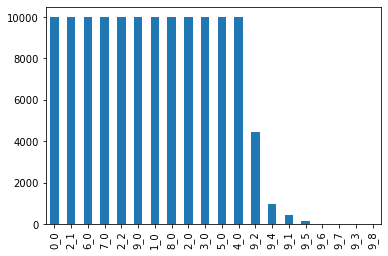

In [14]:
limited.signature_type.value_counts().plot.bar()

In [15]:
limited.shape

(126016, 3)

In [16]:
%%time
chips = df.geometry.values[limited.ids_tgt.values].data
sig = signatures.geometry.values[limited.ids_src.values].data

# this could be parallelised
r = [
    pygeos.clip_by_rect(
        g, *chip
    ) for g, chip in zip(sig, pygeos.bounds(chips))
]

areas = pygeos.area(r)

table = coo_matrix(
    (
        areas,
        (limited.ids_src.values, limited.ids_tgt.values),
    ),
    shape=(signatures.shape[0], df.shape[0]),
    dtype=numpy.float32,
)

table = table.tocsr()

CPU times: user 1min 4s, sys: 7.31 ms, total: 1min 4s
Wall time: 1min 4s


In [17]:
%%time
signatures["signature_type"] = pandas.Categorical(signatures["signature_type"])

CPU times: user 16.5 ms, sys: 13 µs, total: 16.5 ms
Wall time: 15.2 ms


In [18]:
%%time
categorical = {}
for value in signatures["signature_type"].unique():
    mask = signatures["signature_type"] == value
    categorical[value] = numpy.asarray(
        table[mask].sum(axis=0)
    )[0]
    print(value)

0_0
1_0
3_0
4_0
5_0
6_0
7_0
8_0
2_0
2_1
2_2
9_0
9_1
9_2
9_3
9_4
9_5
9_6
9_7
9_8
CPU times: user 142 ms, sys: 55.9 ms, total: 198 ms
Wall time: 194 ms


In [19]:
%%time
categorical = pandas.DataFrame(categorical)

CPU times: user 89.5 ms, sys: 52.1 ms, total: 142 ms
Wall time: 139 ms


In [20]:
%time areas = df.area.values
%time categorical = categorical.div(areas, axis="rows")

CPU times: user 222 ms, sys: 4.05 ms, total: 226 ms
Wall time: 224 ms
CPU times: user 177 ms, sys: 100 ms, total: 277 ms
Wall time: 276 ms


In [21]:
geom = df[df.geometry.name].reset_index(drop=True)
ests = geopandas.GeoDataFrame(categorical, geometry=geom, crs=signatures.crs)

In [22]:
ests = ests.iloc[limited.ids_tgt.values]

<AxesSubplot:>

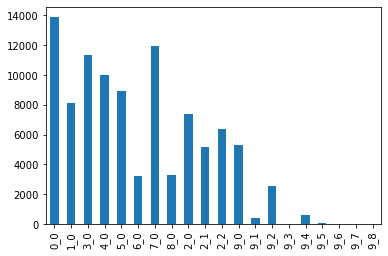

In [23]:
ests.drop(columns="geometry").sum().plot.bar()

In [24]:
ests.to_parquet("/home/jovyan/work/chips_gb/chip_proportions_16.pq")

/tmp/ipykernel_37076/4040811636.py:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  ests.to_parquet("/home/jovyan/work/chips_gb/chip_proportions_16.pq")


<AxesSubplot:>

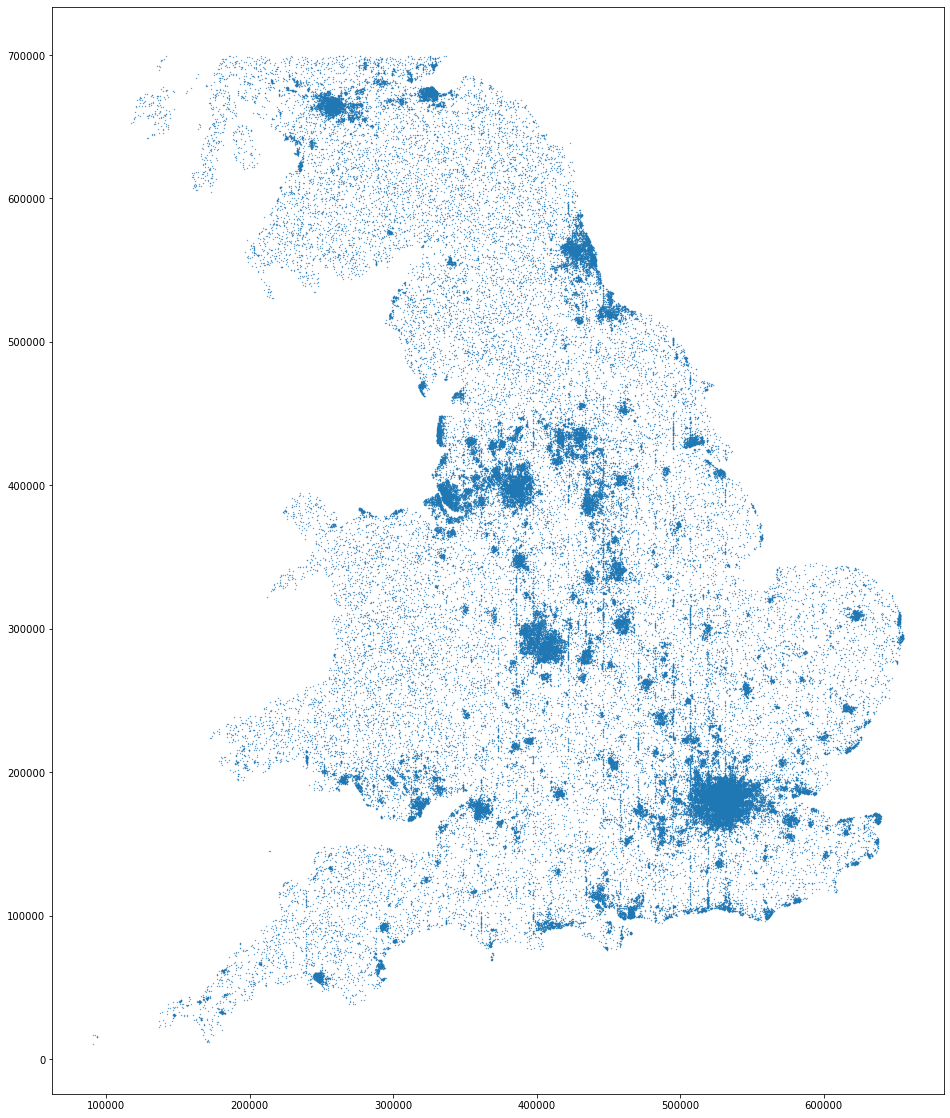

In [25]:
ests.centroid.plot(figsize=(20, 20), markersize=.1)

Create chips

In [26]:
specs = {
    'chip_size': 16,
    'bands': [1, 2, 3], #RGB
    'mosaic_p': (
        '/home/jovyan/work/urbangrammar_samba/'
        'ghs_composite_s2/GHS-composite-S2.vrt'
    ),
}

In [27]:
bounds = geopandas.read_parquet("/home/jovyan/work/chips_gb/chip_proportions_16.pq")

In [28]:
centroid = bounds.centroid
bounds['X'] = centroid.x.astype(int)
bounds['Y'] = centroid.y.astype(int)

In [29]:
client = Client(
    LocalCluster(n_workers=16, threads_per_worker=1)
)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 16,Total memory: 125.54 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45269,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 125.54 GiB
Comm: tcp://127.0.0.1:45561,Total threads: 1
Dashboard: http://127.0.0.1:46417/status,Memory: 7.85 GiB
Nanny: tcp://127.0.0.1:34731,


In [30]:
import numpy as np

def bag_of_chips(chip_bbs, specs, npartitions):
    '''
    Load imagery for `chip_bbs` using a Dask bag
    ...
    
    Arguments
    ---------
    chip_bbs : GeoDataFrame
               Geo-table with bounding boxes of the chips to load
    specs : dict
            Metadata dict, including, at least:
            - `bands`: band index of each band of interest
            - `chip_size`: size of each chip size expressed in pixels
            - `mosaic_p`: path to the mosaic/file of imagery
    npartitions : int
                  No. of partitions to split `chip_bbs` before sending to
                  Dask for distributed computation
    Returns
    -------
    chips : ndarray
            Numpy tensor of (N, chip_size, chip_size, n_bands) dimension 
            with imagery data   
    '''
    # Split chip_bbs
    thr = np.linspace(0, chip_bbs.shape[0], npartitions+1, dtype=int)
    chunks = [
        (chip_bbs.iloc[thr[i]:thr[i+1], :], specs) for i in range(len(thr)-1)
    ]
    # Set up the bag
    bag = dask.bag.from_sequence(
        chunks, npartitions=npartitions
    ).map(chip_loader)
    # Compute
    chips = np.concatenate(bag.compute())
    return chips


def chip_loader(pars):
    '''
    Load imagery for `chip_bbs`
    ...
    
    Arguments (wrapped in `pars`)
    -----------------------------
    chip_bbs : GeoDataFrame
               Geo-table with bounding boxes of the chips to load
    specs : dict
            Metadata dict, including, at least:
            - `bands`: band index of each band of interest
            - `chip_size`: size of each chip size expressed in pixels
            - `mosaic_p`: path to the mosaic/file of imagery
    Returns
    -------
    chips : ndarray
            Numpy tensor of (N, chip_size, chip_size, n_bands) dimension 
            with imagery data
    '''
    chip_bbs, specs = pars
    b = len(specs['bands'])
    s = specs['chip_size']
    chips = np.zeros((chip_bbs.shape[0], b, s, s))
    with rasterio.open(specs['mosaic_p']) as src:
        for i, tup in enumerate(chip_bbs.itertuples()):
            img, transform = rasterio.mask.mask(
                src, [tup.geometry], crop=True, all_touched=True
            )
            img = img[:b, :s, :s]
            for ban, (l_min, l_max) in enumerate([(350, 1600), (500, 1600), (600, 1800)]):
                img[ban][img[ban] > l_max] = l_max
                img[ban][img[ban] < l_min] = l_min
                a_std = (img[ban] - l_min) / (l_max - l_min)
                img[ban] = a_std * 255
            chips[i, :, :, :] = img
    chips = np.moveaxis(chips, 1, -1)
    return chips.astype(rasterio.uint8)

In [31]:
chips = bag_of_chips(bounds, specs, 16)

In [32]:
numpy.save('../../chips_gb/multilabel_chip_16.npy', chips)